# Flipping USB Connectors


In [1]:
import numpy as np
import pandas as pd

*If you like this article, you might also like the second edition of [*Think Bayes*](https://greenteapress.com/wp/think-bayes/).*

[Click here to run this article on Colab](https://colab.research.google.com/github/AllenDowney/ThinkBayes2/blob/master/examples/usb.ipynb)

I would not be the first person to observe that it sometimes takes several tries to plug in a USB connector (specifically the rectangular [Type A connector](https://en.wikipedia.org/wiki/USB), which is not reversible).
On Quora alone,
[people](https://www.quora.com/Why-do-you-always-have-to-flip-a-USB-twice-when-trying-to-plug-it-in-Shouldn-t-it-have-gone-in-the-first-time-when-you-had-it-the-right-way)
[have](https://www.quora.com/There-is-a-50-chance-of-plugging-in-a-USB-cable-the-right-way-on-the-first-try-Why-does-it-only-happen-20-of-the-time-when-I-do-it)
[asked](https://www.quora.com/Why-doesnt-the-USB-go-in-the-first-time-but-does-after-youve-turn-it-a-few-times)
[about](https://www.quora.com/People-that-can-plug-the-USB-in-on-their-first-try-How)
[it](https://www.quora.com/Why-cant-we-plug-in-USB-devices-correctly-the-first-time) more than once.

But I hope I am the first person to figure out the optimal strategy for plugging in a USB connector. Specifically, I have worked out how long you should try on the first side before flipping, and how long you should try on the second side before flipping again.

Of course, my analysis is based on some modeling assumptions:

1) Initially, the probability is 0.5 that the connector is in the right orientation.

2) If it is, the time it takes to succeed follows an exponential distribution with rate parameter 1.1, which means that it takes 0.91 seconds on average.

3) Flipping the connector takes 0.1 seconds.

With that, we are ready to get started.

The first step is to figure out the probability that the connector is in the right orientation as a function of how long you have been trying.
For that, we can use a Bayes table, which is a form of Bayes's Theorem I use in [Chapter 2 of *Think Bayes*](https://allendowney.github.io/ThinkBayes2/chap02.html#bayes-tables).

The following function takes a sequence of hypotheses, prior probabilities, and likelihoods, and turns a pandas `DataFrame` that represents a Bayes table.

In [2]:
def bayes_table(hypos, prior, likelihood):
    """Make a table showing a Bayesian update."""
    table = pd.DataFrame(dict(prior=prior, likelihood=likelihood), index=hypos)
    table['unnorm'] = table['prior'] * table['likelihood']
    prob_data = table['unnorm'].sum()
    table['posterior'] = table['unnorm'] / prob_data
    return table

Now suppose that the initial probability is 0.5 that the orientation of the connector is correct, and you have been trying for 0.9 second.
What is the likelihood that you would have to try so long?

* If you are on the wrong side, it is 100%.

* If you are on the right side, it's given by the survival function (complementary CDF) of the exponential distribution, which is $\exp(-\lambda t)$, where $\lambda$ is the rate parameter and $t$ is time.

The following function computes this likelihood:

In [3]:
def expo_sf(t, lam):
    return np.exp(-lam * t)

We can use this function to compute the likelihood of trying for 0.9 seconds or more, given $\lambda=1.1$.

In [4]:
t = 0.9
lam = 1.1

expo_sf(t, lam)

0.37157669102204566

Now let's make a Bayes table with two hypotheses -- the connector is either the right way or the wrong way -- with equal prior probabilities.

In [5]:
hypos = ['Right way', 'Wrong way']
prior = [1/2, 1/2]

And here are the likelihoods of the data for each hypothesis:

In [6]:
likelihood = [expo_sf(t, lam), 1]

Putting it together, here's the Bayes table.

In [7]:
bayes_table(hypos, prior, likelihood)

,prior,likelihood,unnorm,posterior
Right way,0.5,0.371577,0.185788,0.270912
Wrong way,0.5,1.000000,0.500000,0.729088


After 0.9 seconds, the probability is about 73% that the orientation of the connector is wrong, so you might want to think about trying the other side.

But if it takes 0.1 seconds to flip, maybe you should keep trying a little longer. To figure out when to flip, let's do the same analysis again for general values of $\lambda$ and $t$.

## Generalization

To minimize human error, I like to get Sympy to do the algebra. Here are the symbols I'll use.

In [8]:
from sympy import symbols, exp

t, lam, p, q, r = symbols('t lam p q r')

Here's the likelihood again, using the symbols.

In [9]:
likelihood = [exp(-lam * t), 1]
likelihood

[exp(-lam*t), 1]

And here's the Bayes table, using $p$ and $q$ for the prior probabilities of the hypotheses.

In [11]:
prior = [p, q]
table = bayes_table(hypos, prior, likelihood)
table

,prior,likelihood,unnorm,posterior
Right way,p,exp(-lam*t),p*exp(-lam*t),p*exp(-lam*t)/(p*exp(-lam*t) + q)
Wrong way,q,1,q,q/(p*exp(-lam*t) + q)


From the table I'll select the posterior probability that the orientation is correct.

In [12]:
expr = table.loc['Right way', 'posterior']
expr

p*exp(-lam*t)/(p*exp(-lam*t) + q)

You might recognize this as a form of the [logistic function](https://en.wikipedia.org/wiki/Logistic_function). With the substitution `odds = p/q` we can compute it like this:

In [13]:
def logistic(p, lam, t):
    q = 1-p
    odds = q / p
    return 1 / (1 + odds * np.exp(lam * t))

Let's see what that looks like for a range of values of `t`, assuming that the initial probability is `0.5`.

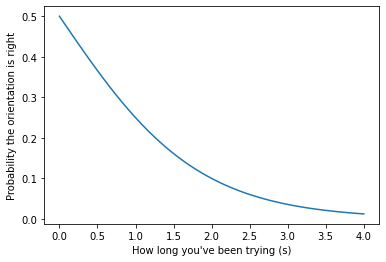

In [14]:
import matplotlib.pyplot as plt

ts = np.linspace(0, 4)
ps = logistic(0.5, 1.1, ts)

plt.plot(ts, ps)
plt.xlabel("How long you've been trying (s)")
plt.ylabel("Probability the orientation is right");

After a few seconds, you would be reasonably convinced that the orientation is wrong.

## Strategy

Now, let's think about turning belief into action. Let me start with a conjecture: I suspect that the best strategy is to try on the first side until the probability of correct orientation drops below some threshold (to be determined), then try on the second side until the probability drops below that threshold again, and repeat until success.

To test this strategy, we will have to figure out how long to try as a function of the prior probability, `p`, and the threshold probability, `r`. Again, I'll make Sympy do the work.

Here's the equation that sets the posterior probability to `r`.

In [15]:
from sympy import Eq, solve

eqn = Eq(expr, r)
eqn

Eq(p*exp(-lam*t)/(p*exp(-lam*t) + q), r)

And here's the solution.

In [16]:
solve(eqn, t)[0]

log(p*(1 - r)/(q*r))/lam

And here's how we can express this solution in terms of the prior and posterior odds.

In [17]:
def wait_time(p, lam, r):
    prior_odds = p / (1-p)
    posterior_odds = r / (1-r)
    return np.log(prior_odds / posterior_odds) / lam

Let's see what that looks like for a range of values of `r`, assuming that the prior probability is `0.5`.

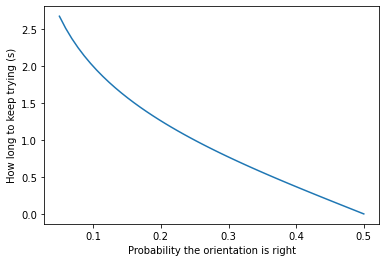

In [18]:
rs = np.linspace(0.05, 0.5)
ts = wait_time(0.5, 1.1, rs)

plt.plot(rs, ts)
plt.xlabel("Probability the orientation is right")
plt.ylabel("How long to keep trying (s)");

When the threshold is low, we have to wait a few seconds to reach it. As the threshold increases, the time to reach is decreases. 

## Simulation

As a step toward optimization, let's run a simulation. The following function takes as parameters:

* `correct`: A Boolean indicating if the orientation is correct.
* `p`: The prior probability that the orientation is correct.
* `lam`: The rate parameter for the distribution of time until success.
* `r`: The threshold for the posterior probability.
* `flip`: The time it takes to flip the connector, in seconds.
* `trace`: A list that indicates how much time we have spent, so far, trying and flipping.



In [19]:
def simulate(correct, p, lam, r, flip, trace):
    # figure out the maximum time we should try before flipping
    wait = wait_time(p, lam, r)
    
    # if we're on the correct side, see if we succeed before time's up
    if correct:
        t = np.random.exponential(1/lam)
        if t < wait:
            # if so, update and return the trace
            return trace + [t]
    
    # if time expired, add the wait time and flip time to the trace  
    # and make a recursive call to continue the simulation
    return simulate(not correct, 1-r, lam, r, flip, trace + [wait, flip])

Here's a test run if we start on the correct side.

In [20]:
simulate(correct=True, p=0.5, lam=1.1, r=0.2, flip=0.1, trace=[])

[0.2757566248610881]

And here's a run where we start on the wrong side.

In [21]:
simulate(correct=False, p=0.5, lam=1.1, r=0.2, flip=0.1, trace=[])

[1.2602676010180822, 0.1, 0.9257473294907383]

Now here's a function that runs the simulation many times, starting in the right orientation half the time, and with prior probability `p=0.5`.

It returns two arrays, containing the length of the trace and the total duration for each simulation.

In [22]:
def run_simulations(lam, r, flip, iters=20000):
    res = []
    for i in range(iters):
        correct = i%2
        trace = simulate(correct, 0.5, lam, r, flip, [])
        res.append((len(trace), sum(trace)))
        
    return np.transpose(res)

Here's the average total duration with threshold probability `r=0.25`.

In [23]:
lengths, totals = run_simulations(lam=1.1, r=0.25, flip=0.1)
totals.mean()

2.017637828167076

With this threshold, it takes about 2 seconds to connect, on average.

## Optimization

Now let's see how the average duration varies as we sweep through a range of values for the threshold probability, `r`:

In [25]:
rs = np.linspace(0.15, 0.4, 21)
rs

array([0.15  , 0.1625, 0.175 , 0.1875, 0.2   , 0.2125, 0.225 , 0.2375,
       0.25  , 0.2625, 0.275 , 0.2875, 0.3   , 0.3125, 0.325 , 0.3375,
       0.35  , 0.3625, 0.375 , 0.3875, 0.4   ])

In [26]:
np.random.seed(17)

res = []
for r in rs:
    lengths, totals = run_simulations(lam=1.1, r=r, flip=0.1)
    res.append((r, totals.mean()))

In [27]:
from statsmodels.nonparametric.smoothers_lowess import lowess

def make_lowess(series):
    """Use LOWESS to compute a smooth line.

    series: pd.Series

    returns: pd.Series
    """
    endog = series.values
    exog = series.index.values

    smooth = lowess(endog, exog)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=index)

In [28]:
def plot_series_lowess(series, color):
    """Plots a series of data points and a smooth line.

    series: pd.Series
    color: string or tuple
    """
    series.plot(lw=0, marker='o', color=color, alpha=0.5)
    smooth = make_lowess(series)
    smooth.plot(label='_', color=color)

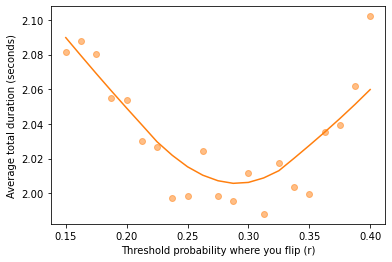

In [29]:
rs, ts = np.transpose(res)
series = pd.Series(ts, rs)

plot_series_lowess(series, 'C1')

plt.xlabel("Threshold probability where you flip (r)")
plt.ylabel("Average total duration (seconds)");

It looks like the optimal value of `r` is close to `0.3`, maybe `0.29`.

With that threshold we can see how long we should try on the first side, starting with prior probability `p=0.5`.

In [30]:
r_opt = 0.29
wait_time(p=0.5, lam=1.1, r=r_opt)

0.813985497322583

With the given values of `lam` and `flip`, it turns out the optimal time to weight is about `0.8` seconds.

If we have to flip, the prior probability for the second side is `p=1-r`, so we have to weight twice as long for the posterior probability to get down to `r`.

In [31]:
wait_time(p=1-r_opt, lam=1.1, r=r_opt)

1.627970994645166

## How many flips?

Now let's run the simulations with the optimal value of `r` and see what the distributions look like for the total time and the number of flips.

In [32]:
lengths, totals = run_simulations(lam=1.1, r=r_opt, flip=0.1)

Here's the distribution of total time, represented as a CDF.

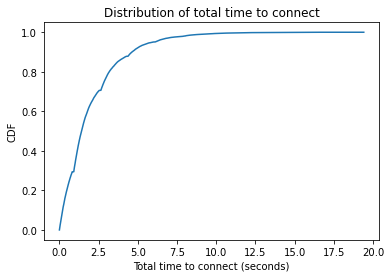

In [33]:
from empiricaldist import Cdf

Cdf.from_seq(totals).plot()

plt.xlabel('Total time to connect (seconds)')
plt.ylabel('CDF')
plt.title('Distribution of total time to connect');

And here's the distribution for the total number of flips.

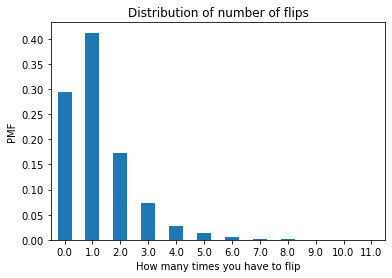

In [34]:
from empiricaldist import Pmf

flips = (lengths-1) // 2
Pmf.from_seq(flips).bar()

plt.xlabel('How many times you have to flip')
plt.ylabel('PMF')
plt.title('Distribution of number of flips');

The probability of getting it right on the first try is only about 30%. That might seem low, because the chance of starting in the right orientation is 50%, but remember that we have a substantial chance of flipping even if we start in the right orientation (and in that case, we will have to flip at least twice).

The most common outcome is that we have to flip once, about 40% of the time. And the probability of the notorious double-flip is 15-20%. 

Fortunately, it is rare to flip three or more times.

## Summary

With that, I think we have solved the USB connection problem.

1. For given parameters `lam` and `flip`, we can find the threshold probability, `r`, that minimizes the average time to connect.

2. Given this optimal value, we can estimate the distribution of total time and the number of times we have to flip.

Sadly, all of this fun is gradually being spoiled by the encroachment of the [USB-C](https://en.wikipedia.org/wiki/USB-C) connector, which is reversible.

*If you like this article, you might also like the second edition of [*Think Bayes*](https://greenteapress.com/wp/think-bayes/).*

Copyright 2021 Allen Downey

Code: [MIT License](https://opensource.org/licenses/MIT)

Text: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)